In [1]:
import torch
import json
import os

configs = {
    "train_source_data":"/content/train.en",
    "train_target_data":"/content/train.de",
    "valid_source_data":"/content/val.en",
    "valid_target_data":"/content/val.de",
    "source_tokenizers":"bert-base-uncased",
    "target_tokenizers":"vinai/phobert-base",
    "source_max_seq_len":256,
    "target_max_seq_len":256,
    "batch_size":20,
    "device":"cuda:0" if torch.cuda.is_available() else "cpu",
    "embedding_dim": 512,
    "n_layers": 6,
    "n_heads": 8,
    "dropout": 0.1,
    "lr":0.0001,
    "n_epochs":12,
    "print_freq": 5,
    "beam_size":3,
    "model_path":"./model_transformer_translate_en_vi.pt",
    "early_stopping":5
}

import matplotlib.pyplot as plt

# visualize log
def plot_loss(log_path, log_dir):
    log = json.load(open(log_path, "r"))

    plt.figure()
    plt.plot(log["train_loss"], label="train loss")
    plt.plot(log["valid_loss"], label="valid loss")
    plt.title("Loss per epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(log_dir, "loss_epoch.png"))

    # plot batch loss
    plt.figure()
    lst = log["train_batch_loss"]
    n = int(len(log["train_batch_loss"]) / len(log["valid_batch_loss"]))
    train_batch_loss = [lst[i:i + n][0] for i in range(0, len(lst), n)]
    plt.plot(train_batch_loss, label="train loss")
    plt.plot(log["valid_batch_loss"], label="valid loss")
    plt.title("Loss per batch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(log_dir, "loss_batch.png"))



In [2]:
pip install -U SoMaJo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 1.5 MB/s eta 0:00:00


In [6]:
import torch
import numpy as np
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
import re
import io
from collections import Counter
from torchtext.data.functional import generate_sp_model, load_sp_model, sentencepiece_tokenizer, sentencepiece_numericalizer
from torchtext.data.functional import numericalize_tokens_from_iterator
import sentencepiece as spm
import pandas as pd
from collections import defaultdict
from pathlib import Path
from torchtext.vocab import vocab
from somajo import SoMaJo


class TrainTranslateDataset(Dataset):
    def __init__(self, source_data=None, target_data=None, source_max_seq_len=256, target_max_seq_len=256, phase="train"):
        self.source_data = source_data
        self.target_data = target_data
        #self.source_tokenizer = source_tokenizer
        #self.target_tokenizer = target_tokenizer
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.phase = phase
        #self.vocab_dict=vocab_dict
        #self.new_dict=new_dict

        source_path='/content/train.en'
        target_path='/content/train.de'
        source_data = open(source_path).read()
        target_data= open(target_path).read()
        srce_file_path = "eng_traintext_file.txt"
        targ_file_path= "german_traintext_file.txt"
        with open(srce_file_path, "w") as file:
         # 문자열들을 파일에 쓰기
          file.writelines(source_data)

        with open(targ_file_path, "w") as file:
         # 문자열들을 파일에 쓰기
          file.writelines(target_data)




        def preprocess_seq(seq):
          seq = re.sub(
          r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = re.sub(r" ", "\u2581", seq)
          seq = seq.lower()
          return seq

        def targ_preprocess_seq(seq):
          seq = re.sub(
          r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = seq.lower()
          return seq

        #source,target 토크나이징
        self.source= spm.SentencePieceTrainer.train('--input=eng_traintext_file.txt  --model_prefix=wmt2016en --vocab_size=28000 --model_type=bpe --max_sentence_length=500')
        sp = spm.SentencePieceProcessor()
        sp.Load('wmt2016en.model')
        target_tokenizer = SoMaJo("de_CMC", split_camel_case=True)


       # print("source is : "+ source_data[10:100])

        #source array
        with open(srce_file_path, "r") as file:
         self.source_array=[]
         for i in range(29000):
          source_line=file.readline()
          source_result=preprocess_seq(source_line)
          self.source_tokens=sp.EncodeAsPieces(source_result)
          self.source_array.append(self.source_tokens)

        #target array
        with open(targ_file_path, "r") as file:
         self.target_array=[]
         for i in range(29000):
          target_line=file.readline()
          target_result=targ_preprocess_seq(target_line)
          #print([target_result])
          sentences = target_tokenizer.tokenize_text([target_result])
          for sentence in sentences:
             sentence_tokens = [token.text for token in sentence]
             self.target_array.append(sentence_tokens)
         #print(self.target_array)



        #source dict로 변환
        self.source_vocab_dict = {}
        self.source_new_dict={}
        with open("wmt2016en.vocab", "r", encoding="utf-8") as f:
            for line in f:
              source_word, source_index = line.strip().split('\t')  # 탭 문자로 분리
              self.source_vocab_dict[source_word] = int(source_index)
              self.source_new_dict = {key:abs(value) for key, value in self.source_vocab_dict.items()}
              self.source_new_dict[0] = '<PAD>'



        def frequency_of_vocab(data):
          flattened_list = [item for sublist in data for item in sublist]

          element_count = Counter(flattened_list)
          element_count_dict = dict(element_count)


          #words = ' '.join(data)
          #list로 변
          #words = words.split(data)

         #몇번 반복되는지 확인해주는 counter
         #counter = Counter(data)
         #print(len(counter))
         #오름차순으로 정렬
          vocab = sorted(element_count_dict, key=element_count_dict.get, reverse=True)
         #1위부터 매핑
          int2word = dict(enumerate(vocab, 1))
         #순서반대
          int2word[0] = '<PAD>'
          self.word2int = {word: id for id, word in int2word.items()}
          print(len(self.word2int))
          return self.word2int


        def longlist(source_enc):
          length=max(len(elem)for elem in source_enc)
          return length


        self.target_new_dict=frequency_of_vocab(self.target_array)

        self.source_enc=[[self.source_new_dict[value] for value in eng] for eng in tqdm(self.source_array)]
        self.target_enc=[[self.target_new_dict[value] for value in eng] for eng in tqdm(self.target_array)]

        def pad_features(sources, pad_id, seq_length):

          features = np.full((len(sources), seq_length), pad_id, dtype=int)

          for i, row in enumerate(sources):
          # if seq_length < len(row) then review will be trimmed
          #print(i,len(row))

            features[i, :len(row)] = np.array(row)[:seq_length]
          #print(features[0])

          return features

        seq_length = 64

        #<pad>으로 채워주자
        self.source_features = pad_features(self.source_enc, pad_id=0, seq_length=seq_length)
        self.target_features = pad_features(self.target_enc, pad_id=0, seq_length=seq_length)
        #print(target_features[0:2])



    def __len__(self):
        return len(self.source_data)

    # create decoder input mask
    def create_decoder_mask(self, seq_len):
        mask = torch.ones(seq_len, seq_len).tril()
        return mask

    def __getitem__(self, index):
        # source_seq, source_idx = self.convert_line_uncased(
        #     tokenizer=self.source_tokenizer,
        #     text=self.preprocess_seq(self.source_data[index]),
        #     max_seq_len=self.source_max_seq_len
        # )
        # target_seq, target_idx = self.convert_line_uncased(
        #     tokenizer=self.target_tokenizer,
        #     text=self.preprocess_seq(self.target_data[index]),
        #     max_seq_len=self.target_max_seq_len
        # )


        source=pd.DataFrame({"input_ids":self.source_features[index]})
        source=source["input_ids"].tolist()
        source = torch.tensor(source)

        target=pd.DataFrame({"input_ids":self.target_features[index]})
        target=target["input_ids"].tolist()
        target = torch.tensor(target)

        return {
                "source_seq": self.source_data[index],
                "source_ids": source,
                "target_seq": self.target_data[index],
                "target_ids": target,
                }
        #else:
            #return {
               # "source_seq": self.source_data[index],
               # "source_ids": source["input_ids"][0],
           # }


def main():

    def read_data(source_file, target_file):
        source_data = open(source_file).read().strip().split("\n")
        target_data = open(target_file).read().strip().split("\n")
        return source_data, target_data

    train_src_data, train_trg_data = read_data(configs["train_source_data"], configs["train_target_data"])
    valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])

    #source_tokenizer = AutoTokenizer.from_pretrained(configs["source_tokenizer"])
    #target_tokenizer = AutoTokenizer.from_pretrained(configs["target_tokenizer"])
    train_dataset = TrainTranslateDataset(
        #source_tokenizer=source_tokenizer,
        #target_tokenizer=target_tokenizer,
        source_data=train_src_data,
        target_data=train_trg_data,
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"]
    )


    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=configs["batch_size"],
        shuffle=True
    )

    for batch in train_loader:
        print(batch["source_seq"])
        print(batch["target_seq"])
        print(batch["source_ids"])
        print(batch["target_ids"])
        break




if __name__ == "__main__":
    main()


17831


100%|██████████| 29000/29000 [00:00<00:00, 79773.67it/s]


['A man in a dark hat and glasses is reaching into a bowl on a table filled with various bowls.', 'The number five Miami player dribbles down the court.', 'People are buying food from a temporary food vendor.', 'Two people walking down a city street at night', 'A man and a woman stand facing each other in front of a silver-colored wall.', 'Four people standing outside of the white house.', 'Two men in an art booth are talking to each other', "A man in gray holds his dog's leash while his son sits on his shoulders.", 'Small child in knit hat and coat holds a snow shovel in a snowdrift.', 'A little boy sitting outside on the patio, coloring a picture.', 'Man in sleeveless shirt and shorts standing in the middle of the floor.', 'Two young people are approached by a flamboyant young woman dressed in a red bikini and a red feathered headress.', 'The girl is pointing at a geyser', 'There are two brown dogs playing in field.', 'Two people are working at a coffee shop', 'This wedding photo sho

In [8]:
class ValidTranslateDataset(Dataset):
    def __init__(self, source_data=None, target_data=None, source_max_seq_len=256, target_max_seq_len=256, phase="valid"):
        self.source_data = source_data
        self.target_data = target_data
        #self.source_tokenizer = source_tokenizer
        #self.target_tokenizer = target_tokenizer
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.phase = phase
        #self.vocab_dict=vocab_dict
        #self.new_dict=new_dict

        source_path='/content/val.en'
        target_path='/content/val.de'
        source_data = open(source_path).read()
        target_data= open(target_path).read()
        srce_file_path = "eng_valtext_file.txt"
        targ_file_path= "german_valtext_file.txt"
        with open(srce_file_path, "w") as file:
         # 문자열들을 파일에 쓰기
          file.writelines(source_data)

        with open(targ_file_path, "w") as file:
         # 문자열들을 파일에 쓰기
          file.writelines(target_data)




        def preprocess_seq(seq):
          seq = re.sub(
          r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = re.sub(r" ", "\u2581", seq)
          seq = seq.lower()
          return seq

        def targ_preprocess_seq(seq):
          seq = re.sub(
          r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = seq.lower()
          return seq

        #source,target 토크나이징
        self.source= spm.SentencePieceTrainer.train('--input=eng_valtext_file.txt  --model_prefix=wmt2016enval --vocab_size=7000 --model_type=bpe --max_sentence_length=300')
        sp = spm.SentencePieceProcessor()
        sp.Load('wmt2016enval.model')
        target_tokenizer = SoMaJo("de_CMC", split_camel_case=True)


       # print("source is : "+ source_data[10:100])

        #source array
        with open(srce_file_path, "r") as file:
         self.source_array=[]
         for i in range(29000):
          source_line=file.readline()
          source_result=preprocess_seq(source_line)
          self.source_tokens=sp.EncodeAsPieces(source_result)
          self.source_array.append(self.source_tokens)

        #target array
        with open(targ_file_path, "r") as file:
         self.target_array=[]
         for i in range(29000):
          target_line=file.readline()
          target_result=targ_preprocess_seq(target_line)
          sentences = target_tokenizer.tokenize_text([target_result])
          for sentence in sentences:
             sentence_tokens = [token.text for token in sentence]
             self.target_array.append(sentence_tokens)
         #print(self.target_array)



        #source dict로 변환
        self.source_vocab_dict = {}
        self.source_new_dict={}
        with open("wmt2016enval.vocab", "r", encoding="utf-8") as f:
            for line in f:
              source_word, source_index = line.strip().split('\t')  # 탭 문자로 분리
              self.source_vocab_dict[source_word] = int(source_index)
              self.source_new_dict = {key:abs(value) for key, value in self.source_vocab_dict.items()}
              self.source_new_dict[0] = '<PAD>'



        def frequency_of_vocab(data):
          flattened_list = [item for sublist in data for item in sublist]

          element_count = Counter(flattened_list)
          element_count_dict = dict(element_count)


          #words = ' '.join(data)
          #list로 변
          #words = words.split(data)

         #몇번 반복되는지 확인해주는 counter
         #counter = Counter(data)
         #print(len(counter))
         #오름차순으로 정렬
          vocab = sorted(element_count_dict, key=element_count_dict.get, reverse=True)
         #1위부터 매핑
          int2word = dict(enumerate(vocab, 1))
         #순서반대
          int2word[0] = '<PAD>'
          self.word2int = {word: id for id, word in int2word.items()}
          print(len(self.word2int))

          return self.word2int


        def longlist(source_enc):
          length=max(len(elem)for elem in source_enc)
          return length


        self.target_new_dict=frequency_of_vocab(self.target_array)

        self.source_enc=[[self.source_new_dict[value] for value in eng] for eng in tqdm(self.source_array)]
        self.target_enc=[[self.target_new_dict[value] for value in eng] for eng in tqdm(self.target_array)]

        def pad_features(sources, pad_id, seq_length):

          features = np.full((len(sources), seq_length), pad_id, dtype=int)

          for i, row in enumerate(sources):
          # if seq_length < len(row) then review will be trimmed
          #print(i,len(row))

            features[i, :len(row)] = np.array(row)[:seq_length]
          #print(features[0])

          return features

        seq_length = 64

        #<pad>으로 채워주자
        self.source_features = pad_features(self.source_enc, pad_id=0, seq_length=seq_length)
        self.target_features = pad_features(self.target_enc, pad_id=0, seq_length=seq_length)
        #print(target_features[0:2])



    def __len__(self):
        return len(self.source_data)

    # create decoder input mask
    def create_decoder_mask(self, seq_len):
        mask = torch.ones(seq_len, seq_len).tril()
        return mask

    def __getitem__(self, index):
        # source_seq, source_idx = self.convert_line_uncased(
        #     tokenizer=self.source_tokenizer,
        #     text=self.preprocess_seq(self.source_data[index]),
        #     max_seq_len=self.source_max_seq_len
        # )
        # target_seq, target_idx = self.convert_line_uncased(
        #     tokenizer=self.target_tokenizer,
        #     text=self.preprocess_seq(self.target_data[index]),
        #     max_seq_len=self.target_max_seq_len
        # )



        source=pd.DataFrame({"input_ids":self.source_features[index]})
        source=source["input_ids"].tolist()
        source = torch.tensor(source)

        target=pd.DataFrame({"input_ids":self.target_features[index]})
        target=target["input_ids"].tolist()
        target = torch.tensor(target)

        return {
                "source_seq": self.source_data[index],
                "source_ids": source,
                "target_seq": self.target_data[index],
                "target_ids": target,
                }
        #else:
            #return {
               # "source_seq": self.source_data[index],
               # "source_ids": source["input_ids"][0],
           # }


def main():

    def read_data(source_file, target_file):
        source_data = open(source_file).read().strip().split("\n")
        target_data = open(target_file).read().strip().split("\n")
        return source_data, target_data

    train_src_data, train_trg_data = read_data(configs["train_source_data"], configs["train_target_data"])
    valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])

    #source_tokenizer = AutoTokenizer.from_pretrained(configs["source_tokenizer"])
    #target_tokenizer = AutoTokenizer.from_pretrained(configs["target_tokenizer"])
    valid_dataset = ValidTranslateDataset(
        #source_tokenizer=source_tokenizer,
        #target_tokenizer=target_tokenizer,
        source_data=valid_src_data,
        target_data=valid_trg_data,
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"]
    )

    valid_dataset[0]

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=configs["batch_size"],
        shuffle=True
    )
    for batch in valid_loader:
        print(batch["source_seq"])
        print(batch["target_seq"])
        print(batch["source_ids"])
        print(batch["target_ids"])
        break




if __name__ == "__main__":
    main()


2265


100%|██████████| 29000/29000 [00:00<00:00, 166064.10it/s]


['Three large dogs enjoy a romp in the snow.', 'Girl in white shirt blowing bubbles in dark room.', '4 people trying to fix a bike on a park', 'A woman in striped tights is being guided with strings.', 'A man in a red baseball cap is leaning against a light pole.', 'A young boy laying on a hospital bed with his leg over the side.', 'A man wearing glasses at the microphone is looking down at some paper in his hand.', 'A man dressed in green snowboarding on a bench.', 'Two people play water volleyball in a pool.', 'A man practices boxing', 'A son and his parents are taking a group picture in a church.', 'People and camels taking a break in the desert.', "Boy's are competing in martial arts.", 'A boy in a blue, playing soccer, about to kick the ball.', 'A man and woman sit across from each other at a restaurant table.', 'Multiple bodies collide in a soccer match.', 'A man in a brightly-colored ski jacket stands with others on a European street.', 'A man in a cluttered office is using the 

In [9]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable

class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Embedding, self).__init__()
        # vocab_size=임베딩을 할 단어들의 개수, embedding_dim은 벡터 사이즈
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

# The positional encoding vector
class PositionalEncoder(nn.Module):
    def __init__(self, embedding_dim, max_seq_length=512, dropout=0.1):
        super(PositionalEncoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_seq_length, embedding_dim)
        for pos in range(max_seq_length):
            #embedding 전까지 2씩 증가
            for i in range(0, embedding_dim, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/embedding_dim)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/embedding_dim)))
        #for ex)[10,10]->[1,10,10]
        pe = pe.unsqueeze(0)
        #버퍼(backpropagation에 안쓰이고 gpu에서 돌아감, 데이터를 전송하면서 임시 보관소)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x*math.sqrt(self.embedding_dim)
        #1
        seq_length = x.size(1)
        #
        pe = Variable(self.pe[:, :seq_length], requires_grad=False).to(x.device)
        # Add the positional encoding vector to the embedding vector
        x = x + pe
        x = self.dropout(x)
        return x

# Self-attention layer
class SelfAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        #key.size=[20, 8, 256, 64]
        #key_dim=64, same as the numbers of the paper
        key_dim = key.size(-1)
        #q*k의 transpose
        attn = torch.matmul(query / np.sqrt(key_dim), key.transpose(2, 3))
        if mask is not None:
            #mask 차원 늘리기
            mask = mask.unsqueeze(1)
            #미래시점의 입력값이 고려되면 안되기 때문에
            attn = attn.masked_fill(mask == 0, -1e9)
        #attn의 마지막 차원에 대해 softmax
        attn = self.dropout(torch.softmax(attn, dim=-1))
        #value랑 곱해주는 부분
        output = torch.matmul(attn, value)

        return output

# Multi-head attention layer
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.self_attention = SelfAttention(dropout)
        # The number of heads
        self.num_heads = num_heads
        # The dimension of each head
        self.dim_per_head = embedding_dim // num_heads
        # The linear projections(fc layer)
        self.query_projection = nn.Linear(embedding_dim, embedding_dim)
        self.key_projection = nn.Linear(embedding_dim, embedding_dim)
        self.value_projection = nn.Linear(embedding_dim, embedding_dim)
        #dropout
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, query, key, value, mask=None):
        # Apply the linear projections
        batch_size = query.size(0)
        query = self.query_projection(query)
        key = self.key_projection(key)
        value = self.value_projection(value)
        # Reshape the input
        query = query.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        # Calculate the attention
        scores = self.self_attention(query, key, value, mask)
        # Reshape the output
        output = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.embedding_dim)
        # Apply the linear projection
        output = self.out(output)
        return output

# Norm layer
class Norm(nn.Module):
    def __init__(self, embedding_dim):
        super(Norm, self).__init__()
        self.norm = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        return self.norm(x)


# Transformer encoder layer
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        #피드포워드 계층
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embedding_dim)
        )

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)

    def forward(self, x, mask=None):
        x2 = self.norm1(x)
        # Add and Muti-head attention
        x = x + self.dropout1(self.self_attention(x2, x2, x2, mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.feed_forward(x2))
        return x

# Transformer decoder layer
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        #masked self attention
        self.self_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        #인코더 디코더 어텐션
        self.encoder_attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embedding_dim)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.norm1 = Norm(embedding_dim)
        self.norm2 = Norm(embedding_dim)
        self.norm3 = Norm(embedding_dim)

    def forward(self, x, memory, source_mask, target_mask):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attention(x2, x2, x2, target_mask))
        x2 = self.norm2(x)
        x = x + self.dropout2(self.encoder_attention(x2, memory, memory, source_mask))
        x2 = self.norm3(x)
        x = x + self.dropout3(self.feed_forward(x2))
        return x

# Encoder transformer
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len, num_heads, num_layers, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([EncoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, source, source_mask):
        # Embed the source
        x = self.embedding(source)
        # Add the position embeddings
        x = self.position_embedding(x)
        # Propagate through the layers
        for layer in self.layers:
            x = layer(x, source_mask)
            a=[]

        # Normalize
        x = self.norm(x)
        return x

# Decoder transformer
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_seq_len,num_heads, num_layers, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.layers = nn.ModuleList([DecoderLayer(embedding_dim, num_heads, 2048, dropout) for _ in range(num_layers)])
        self.norm = Norm(embedding_dim)
        self.position_embedding = PositionalEncoder(embedding_dim, max_seq_len, dropout)

    def forward(self, target, memory, source_mask, target_mask):
        # Embed the source
        x = self.embedding(target)
        # Add the position embeddings
        x = self.position_embedding(x)
        # Propagate through the layers
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        # Normalize
        x = self.norm(x)
        return x


# Transformers
class Transformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, source_max_seq_len, target_max_seq_len, embedding_dim, num_heads, num_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size
        self.source_max_seq_len = source_max_seq_len
        self.target_max_seq_len = target_max_seq_len
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout

        self.encoder = Encoder(source_vocab_size, embedding_dim, source_max_seq_len, num_heads, num_layers, dropout)
        self.decoder = Decoder(target_vocab_size, embedding_dim, target_max_seq_len, num_heads, num_layers, dropout)
        self.final_linear = nn.Linear(embedding_dim, target_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, source, target, source_mask, target_mask):
        # Encoder forward pass
        memory = self.encoder(source, source_mask)
        # Decoder forward pass
        output = self.decoder(target, memory, source_mask, target_mask)
        # Final linear layer
        output = self.dropout(output)
        output = self.final_linear(output)
        return output

    def make_source_mask(self, source_ids, source_pad_id):
        return (source_ids != source_pad_id).unsqueeze(-2)

    def make_target_mask(self, target_ids):
        batch_size, len_target = target_ids.size()
        subsequent_mask = (1 - torch.triu(torch.ones((1, len_target, len_target), device=target_ids.device), diagonal=1)).bool()
        return subsequent_mask


17831


100%|██████████| 29000/29000 [00:00<00:00, 93569.56it/s]


2265


Validating epoch 1/12: 100%|██████████| 51/51 [00:02<00:00, 24.12it/s, loss=7.59]


---- Detect improment and save the best model ----
---- Epoch 1/12 | Train loss: 5.3801 | Valid loss: 7.5407 | Best Valid loss: 7.5407 | Best epoch: 1


Validating epoch 2/12: 100%|██████████| 51/51 [00:01<00:00, 29.01it/s, loss=8.11]


---- Epoch 2/12 | Train loss: 4.0889 | Valid loss: 8.0607 | Best Valid loss: 7.5407 | Best epoch: 1


Validating epoch 3/12: 100%|██████████| 51/51 [00:01<00:00, 29.10it/s, loss=8.32]


---- Epoch 3/12 | Train loss: 3.4162 | Valid loss: 8.3139 | Best Valid loss: 7.5407 | Best epoch: 1


Validating epoch 4/12: 100%|██████████| 51/51 [00:01<00:00, 29.23it/s, loss=8.74]


---- Epoch 4/12 | Train loss: 3.0116 | Valid loss: 8.6667 | Best Valid loss: 7.5407 | Best epoch: 1


Validating epoch 5/12: 100%|██████████| 51/51 [00:01<00:00, 28.45it/s, loss=8.82]


---- Epoch 5/12 | Train loss: 2.7349 | Valid loss: 8.7884 | Best Valid loss: 7.5407 | Best epoch: 1


Validating epoch 6/12: 100%|██████████| 51/51 [00:01<00:00, 27.15it/s, loss=8.78]


---- Early stopping ----


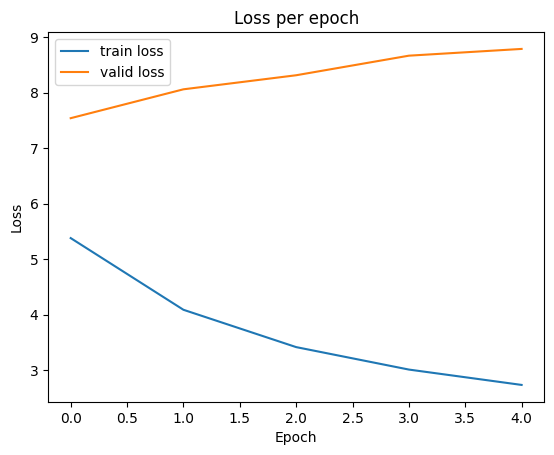

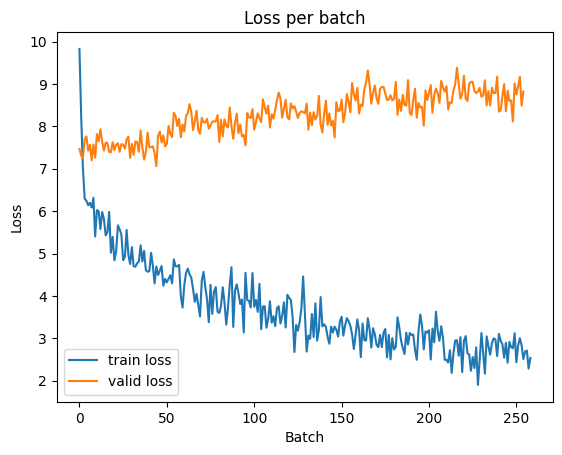

In [11]:
import torch
import torch.nn as nn
import time
import torch.nn.functional as F
from transformers import AutoTokenizer
from tqdm import tqdm
import numpy as np
from datetime import datetime, timedelta
import json
import os



def read_data(source_file, target_file):
    source_data = open(source_file).read().strip().split("\n")
    target_data = open(target_file).read().strip().split("\n")
    return source_data, target_data


def validate_epoch(model, valid_loader, epoch, n_epochs, source_pad_id, target_pad_id, device):
    model.eval()
    total_loss = []
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader), desc=f"Validating epoch {epoch+1}/{n_epochs}")
    for i, batch in bar:
        source, target = batch["source_ids"].to(device), batch["target_ids"].to(device)
        target_input = target[:, :-1]
        source_mask, target_mask = model.make_source_mask(source, source_pad_id), model.make_target_mask(target_input)
        preds = model(source, target_input, source_mask, target_mask)
        gold = target[:, 1:].contiguous().view(-1)
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), gold, ignore_index=target_pad_id)
        total_loss.append(loss.item())
        bar.set_postfix(loss=total_loss[-1])

    valid_loss = sum(total_loss) / len(total_loss)
    return valid_loss, total_loss


def train_epoch(model, train_loader, optim, epoch, n_epochs, source_pad_id, target_pad_id, device):
    model.train()
    total_loss = []
    bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Training epoch {epoch+1}/{n_epochs}")
    for i, batch in bar:
        source, target = batch["source_ids"].to(device), batch["target_ids"].to(device)
        target_input = target[:, :-1]
        source_mask, target_mask = model.make_source_mask(source, source_pad_id), model.make_target_mask(target_input)
        preds = model(source, target_input, source_mask, target_mask)
        optim.zero_grad()
        gold = target[:, 1:].contiguous().view(-1)
        loss = F.cross_entropy(preds.view(-1, preds.size(-1)), gold, ignore_index=target_pad_id)
        loss.backward()
        optim.step()
        total_loss.append(loss.item())
        bar.set_postfix(loss=total_loss[-1])

    train_loss = sum(total_loss) / len(total_loss)
    return train_loss, total_loss


def train(model, train_loader, valid_loader, optim, n_epochs, source_pad_id, target_pad_id, device, model_path, early_stopping):
    log_dir = "./logs"
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    best_val_loss = np.Inf
    best_epoch = 1
    count_early_stop = 0
    log = {"train_loss": [], "valid_loss": [], "train_batch_loss": [], "valid_batch_loss": []}
    for epoch in range(n_epochs):
        train_loss, train_losses = train_epoch(
            model=model,
            train_loader=train_loader,
            optim=optim,
            epoch=epoch,
            n_epochs=n_epochs,
            source_pad_id=source_pad_id,
            target_pad_id=target_pad_id,
            device=device
        )
        valid_loss, valid_losses = validate_epoch(
            model=model,
            valid_loader=valid_loader,
            epoch=epoch,
            n_epochs=n_epochs,
            source_pad_id=source_pad_id,
            target_pad_id=target_pad_id,
            device=device
        )

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            best_epoch = epoch + 1
            # save model
            torch.save(model.state_dict(), model_path)
            print("---- Detect improment and save the best model ----")
            count_early_stop = 0
        else:
            count_early_stop += 1
            if count_early_stop >= early_stopping:
                print("---- Early stopping ----")
                break

        torch.cuda.empty_cache()

        log["train_loss"].append(train_loss)
        log["valid_loss"].append(valid_loss)
        log["train_batch_loss"].extend(train_losses)
        log["valid_batch_loss"].extend(valid_losses)
        log["best_epoch"] = best_epoch
        log["best_val_loss"] = best_val_loss
        log["last_epoch"] = epoch + 1

        with open(os.path.join(log_dir, "log.json"), "w") as f:
            json.dump(log, f)

        print(f"---- Epoch {epoch+1}/{n_epochs} | Train loss: {train_loss:.4f} | Valid loss: {valid_loss:.4f} | Best Valid loss: {best_val_loss:.4f} | Best epoch: {best_epoch}")

    return log


def main():
    train_src_data, train_trg_data = read_data(configs["train_source_data"], configs["train_target_data"])
    valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])
    #source_tokenizer = AutoTokenizer.from_pretrained(configs["source_tokenizer"])
    #target_tokenizer = AutoTokenizer.from_pretrained(configs["target_tokenizer"])

    model = Transformer(
        source_vocab_size=28000,
        target_vocab_size=18000,
        embedding_dim=configs["embedding_dim"],
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
        num_layers=configs["n_layers"],
        num_heads=configs["n_heads"],
        dropout=configs["dropout"]
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    optim = torch.optim.Adam(model.parameters(), lr=configs["lr"], betas=(0.9, 0.98), eps=1e-9)

    train_dataset = TrainTranslateDataset(
        #source_tokenizer=source_tokenizer,
        #target_tokenizer=target_tokenizer,
        source_data=train_src_data,
        target_data=train_trg_data,
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
    )
    valid_dataset = ValidTranslateDataset(
        #source_tokenizer=source_tokenizer,
        #target_tokenizer=target_tokenizer,
        source_data=valid_src_data,
        target_data=valid_trg_data,
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
    )

    device = torch.device(configs["device"])
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=configs["batch_size"],
        shuffle=True
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=configs["batch_size"],
        shuffle=False
    )

    model.to(configs["device"])
    train(model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optim=optim,
        n_epochs=configs["n_epochs"],
        source_pad_id=0,
        target_pad_id=0,
        device=device,
        model_path=configs["model_path"],
        early_stopping=configs["early_stopping"]
    )

    plot_loss(log_path="./logs/log.json", log_dir="./logs")

if __name__ == "__main__":
    main()



In [21]:
import torch
import spacy
from torchtext.data.metrics import bleu_score
import sys


def preprocess_seq(seq):
          seq = re.sub(
          r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = re.sub(r" ", "\u2581", seq)
          seq = seq.lower()
          return seq

def targ_preprocess_seq(seq):
          seq = re.sub(
          r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
          seq = re.sub(r"[ ]+", " ", seq)
          seq = re.sub(r"\!+", "!", seq)
          seq = re.sub(r"\,+", ",", seq)
          seq = re.sub(r"\?+", "?", seq)
          seq = re.sub(r"[^\w\s]", "", seq)
          seq = re.sub(r"\d+", "",seq)
          seq = seq.lower()
          return seq


def pad_features(sources, pad_id, seq_length):

    features = np.full((len(sources), seq_length), pad_id, dtype=int)

    for i, row in enumerate(sources):
      features[i, :len(row)] = np.array(row)[:seq_length]
          #print(features[0])

    return features


def translate_sentence():

    device=torch.device("cpu")

    test_source_path='/content/test_2016_flickr.en'
    src_test_data=open(test_source_path).read()
    src_test_path = "eng_test.txt"
    with open(src_test_path, "w") as file:
         # 문자열들을 파일에 쓰기
          file.writelines(src_test_data)

    # Load english tokenizer
    ssource= spm.SentencePieceTrainer.train('--input=eng_test.txt  --model_prefix=wmt2016entest --vocab_size=4000 --model_type=bpe --max_sentence_length=9999')
    sp = spm.SentencePieceProcessor()
    sp.Load('wmt2016entest.model')

    #load german tokenizer
    target_tokenizer = SoMaJo("de_CMC", split_camel_case=True)


    test_target_path='/content/test_2016_flickr.de'
    source_sentence_array=[]
    target_sentence_array=[]
    source_array2=[]
    target_array2=[]
    with open(test_source_path, "r") as file1:
       for i in range(1000):
          source_line=file1.readline()
          source_sentence_array.append([source_line])
          for line in source_line:
           source_result=preprocess_seq(source_line)
           source_tokens=sp.EncodeAsPieces(source_result)
           source_array2.append(source_tokens)


     #max_length=32

    # Add <SOS> and <EOS> in beginning and end respectively
    #tokens.insert(0, german.init_token)
    #tokens.append(german.eos_token)

    # Go through each german token and convert to an index
    source_vocab_dict = {}
    source_new_dict={}
    with open("wmt2016entest.vocab", "r", encoding="utf-8") as f:
      for line in f:
        source_word, source_index = line.strip().split('\t')  # 탭 문자로 분리
        source_vocab_dict[source_word] = int(source_index)
        source_new_dict = {key:abs(value) for key, value in source_vocab_dict.items()}
        source_new_dict[0] = '<PAD>'

    source_enc=[[source_new_dict[value] for value in eng] for eng in tqdm(source_array2)]
    source_features=pad_features(source_enc, pad_id=0, seq_length=64)
    # Convert to Tensor
    sentence_tensor = torch.LongTensor(source_features).unsqueeze(1).to(device)

    #outputs = [german.vocab.stoi["<sos>"]]
    #for i in range(max_length):
        #trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)

    model = Transformer(
            source_vocab_size=28000,
            target_vocab_size=18000,
            embedding_dim=configs["embedding_dim"],
            source_max_seq_len=configs["source_max_seq_len"],
            target_max_seq_len=configs["target_max_seq_len"],
            num_layers=configs["n_layers"],
            num_heads=configs["n_heads"],
            dropout=configs["dropout"]
              )
        #with torch.no_grad():
    source_mask = model.make_source_mask(source_tensor, source_tokenizer.pad_token_id).to(device)
    target_mask = model.make_target_mask(input_token).to(device)
    output = model(sentence_tensor)
    # Load model Transformer

    print(output)

    #translated_sentence = [english.vocab.itos[idx] for idx in outputs]
    # remove start token
    #return translated_sentence[1:]

translated=translate_sentence()

def bleu(data, model, german, english, device):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["src"]
        trg = vars(example)["trg"]

        prediction = translate_sentence(model, src, german, english, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

  0%|          | 0/1 [12:56<?, ?it/s]

100%|██████████| 62076/62076 [00:00<00:00, 430256.83it/s]


TypeError: Transformer.forward() missing 3 required positional arguments: 'target', 'source_mask', and 'target_mask'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import re
import json
from transformers import AutoTokenizer
from tqdm import tqdm
from torchtext.data.metrics import bleu_score

from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction()


def load_model_tokenizer(configs):
    """
    This function will load model and tokenizer from pretrained model and tokenizer
    """
    device = torch.device(configs["device"])
    source_tokenizers = AutoTokenizer.from_pretrained(configs["source_tokenizers"])
    target_tokenizers = AutoTokenizer.from_pretrained(configs["target_tokenizers"])

    # Load model Transformer
    model = Transformer(
        source_vocab_size=28000,
        target_vocab_size=18000,
        embedding_dim=configs["embedding_dim"],
        source_max_seq_len=configs["source_max_seq_len"],
        target_max_seq_len=configs["target_max_seq_len"],
        num_layers=configs["n_layers"],
        num_heads=configs["n_heads"],
        dropout=configs["dropout"]
    )
    model.load_state_dict(torch.load(configs["model_path"]))
    model.eval()
    model.to(device)
    print(f"Done load model on the {device} device")
    return model, source_tokenizers, target_tokenizers


def translate(model, sentence, source_tokenizer, target_tokenizer, source_max_seq_len=256,
    target_max_seq_len=256, beam_size=3, device=torch.device("cpu"), print_process=False):
    """
    This funciton will translate give a source sentence and return target sentence using beam search
    """
    # Convert source sentence to tensor
    source_tokens = source_tokenizer.encode(sentence)[:source_max_seq_len]
    source_tensor = torch.tensor(source_tokens).unsqueeze(0).to(device)
    # Create source sentence mask
    source_mask = model.make_source_mask(source_tensor, source_tokenizer.pad_token_id).to(device)
    # Feed forward Encoder
    encoder_output = model.encoder.forward(source_tensor, source_mask)
    # Initialize beam list
    beams = [([target_tokenizer.bos_token_id], 0)]
    completed = []
    # Start decoding
    for _ in range(target_max_seq_len):
        new_beams = []
        for beam in beams:
            # Get input token
            input_token = torch.tensor([beam[0]]).to(device)
            # Create mask
            target_mask = model.make_target_mask(input_token).to(device)
            # Decoder forward pass
            pred = model.decoder.forward(input_token, encoder_output, source_mask, target_mask)
            # Forward to linear classify token in vocab and Softmax
            pred = F.softmax(model.final_linear(pred), dim=-1)
            # Get tail predict token
            pred = pred[:, -1, :].view(-1)
            # Get top k tokens
            top_k_scores, top_k_tokens = pred.topk(beam_size)
            # Update beams
            for i in range(beam_size):
                new_beams.append((beam[0] + [top_k_tokens[i].item()], beam[1] + top_k_scores[i].item()))

        import copy
        beams = copy.deepcopy(new_beams)
        # Sort beams by score
        beams = sorted(beams, key=lambda x: x[1], reverse=True)[:beam_size]
        # Add completed beams to completed list and reduce beam size
        for beam in beams:
            if beam[0][-1] == target_tokenizer.eos_token_id:
                completed.append(beam)
                beams.remove(beam)
                beam_size -= 1

        # Print screen progress
        if print_process:
            print(f"Step {_+1}/{target_max_seq_len}")
            print(f"Beam size: {beam_size}")
            print(f"Beams: {[target_tokenizer.decode(beam[0]) for beam in beams]}")
            print(f"Completed beams: {[target_tokenizer.decode(beam[0]) for beam in completed]}")
            print(f"Beams score: {[beam[1] for beam in beams]}")
            print("-"*100)

        if beam_size == 0:
            break


    # Sort the completed beams
    completed.sort(key=lambda x: x[1], reverse=True)
    # Get target sentence tokens
    target_tokens = completed[0][0]
    # Convert target sentence from tokens to string
    target_sentence = target_tokenizer.decode(target_tokens, skip_special_tokens=True)
    return target_sentence


def calculate_bleu_score(model, source_tokenizer, target_tokenizer, configs):
    device = torch.device(configs["device"])
    def preprocess_seq(seq):
        seq = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(seq))
        seq = re.sub(r"[ ]+", " ", seq)
        seq = re.sub(r"\!+", "!", seq)
        seq = re.sub(r"\,+", ",", seq)
        seq = re.sub(r"\?+", "?", seq)
        seq = seq.lower()
        return seq

    valid_src_data, valid_trg_data = read_data(configs["valid_source_data"], configs["valid_target_data"])

    pred_sents = []
    for sentence in tqdm(valid_src_data):
        pred_trg = translate(model, sentence, source_tokenizer, target_tokenizer, configs["source_max_seq_len"], configs["target_max_seq_len"], configs["beam_size"], device)
        pred_sents.append(pred_trg)

    # write prediction to file
    with open("logs/predict_valid.txt", "wb") as f:
        for sent in pred_sents:
            f.write(f"{sent}\n")

    hypotheses = [preprocess_seq(sent).split() for sent in pred_sents]
    references = [[sent.split()] for sent in valid_trg_data]

    weights = [(0.5, 0.5),(0.333, 0.333, 0.334),(0.25, 0.25, 0.25, 0.25)]
    bleu_2 = corpus_bleu(references, hypotheses, weights=weights[0])
    bleu_3 = corpus_bleu(references, hypotheses, weights=weights[1])
    bleu_4 = corpus_bleu(references, hypotheses, weights=weights[2])
    print(f"BLEU-2: {bleu_2} | BLEU-3: {bleu_3} | BLEU-4: {bleu_4}")
    return {"bleu_2": bleu_2, "bleu_3": bleu_3, "bleu_4": bleu_4}


def main():
    model, source_tokenizers, target_tokenizers = load_model_tokenizer(configs)
    bleus = calculate_bleu_score(model, source_tokenizers, target_tokenizers, configs)


if __name__ == "__main__":
    main()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [2]:
import torch
print(torch.cuda.is_available())

True
